# MCMC

Brief notebook that demonstrates the MCMC sampling functionality implemented in this repository. 

In [1]:
from jax.config import config
import numpy as np
import jax.numpy as jnp
from matplotlib import pyplot as plt
import jax
from jax import random

from simplecryoem.mcmc import mcmc, proposal_hmc

In [2]:
%load_ext autoreload
%autoreload 2

config.update("jax_enable_x64", True)
plt.rcParams["figure.figsize"] = 6, 6

(-12.0, 12.0)

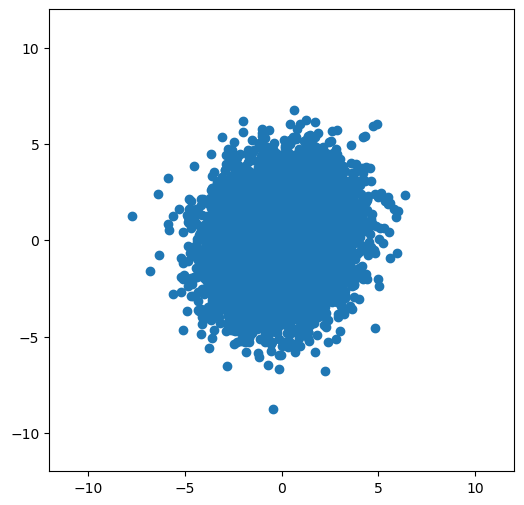

In [3]:
key = random.PRNGKey(int(jnp.floor(np.random.rand() * 1000)))

k = 10
M = jnp.zeros(k)
# c = jnp.array([[1,0],[0,10]])
# c_inv = jnp.array([[1, 0], [0,1/10]])

key, *sk = random.split(key, 4)
V = random.normal(sk[0], [k, k])
Q, _ = jnp.linalg.qr(V)
d = jnp.diag(random.uniform(sk[1], (k,)) * 10)
D = d.at[d < 0].set(0)
C = Q.transpose() @ D @ Q
C_inv = Q.transpose() @ jnp.diag(1 / jnp.diag(D)) @ Q

S = random.multivariate_normal(sk[2], M, C, (10000,))
plt.scatter(S[:, 0], S[:, 1])
plt.xlim(-12, 12)
plt.ylim(-12, 12)

In [4]:
def plot_mcmc_samples(samples, r, x0, M, C):
    plt.rcParams["figure.figsize"] = 16, 8

    plt.subplot(1, 2, 1)
    plt.plot(x0[0], x0[1], "ro")
    plt.scatter(samples[:, 0], samples[:, 1])
    plt.xlim(-20, 20)
    plt.ylim(-20, 20)

    plt.subplot(1, 2, 2)
    plt.plot(r)

    plt.rcParams["figure.figsize"] = 8, 8

    M_est = jnp.mean(samples, axis=0)
    print("Mean error =", jnp.linalg.norm(M - M_est))

    C_est = jnp.cov(samples.transpose())
    print("Covariance error =", jnp.linalg.norm(C - C_est) / jnp.linalg.norm(C))

In [5]:
logPi = lambda x: -1 / 2 * (x - M) @ C_inv @ (x - M) - jnp.log(
    jnp.sqrt((2 * jnp.pi) ** k * jnp.linalg.det(C))
)
gradLogPi = jax.grad(logPi)

pi = lambda x: jnp.exp(logPi(x))
logPi = jax.jit(logPi)
gradLogPi = jax.jit(gradLogPi)

In [6]:
# logPi(jnp.array([10,20]))
# gradLogPi(jnp.array([0.,-5.]))

In [7]:
# x = jnp.arange(-20,20)
# y = [pi(jnp.array([0,xi])) for xi in x]
# plt.plot(x,y)
# plt.show
# y2 = [pi(jnp.array([xi,0])) for xi in x]
# plt.plot(x,y2)
# plt.show()
# y3 = [logPi(jnp.array([0,xi])) for xi in x]
# plt.plot(x,y3)

# gradLogPi(jnp.array([0.,-5.]))

In [8]:
key = random.PRNGKey(int(jnp.floor(np.random.rand() * 1000)))
N_samples = 1000
x0 = jnp.array(np.random.randn(k))

### HMC

In [9]:
N_samples = 1000

In [10]:
@jax.jit
def proposal_hmc_jit(key, x0, logPiX0, dt_list):
    return proposal_hmc(key, x0, logPiX0, logPi, gradLogPi, dt_list, L=100)

In [11]:
logPiX0 = jnp.inf
print(logPi(x0))
dt_list = jnp.array([0.1])
x1, r, logPiX1, logPiX0 = proposal_hmc_jit(key, x0, logPiX0, dt_list)

print(logPiX0)
logPiX1

-15.80392541614921
-15.80392541614921


Array(-17.07914341, dtype=float64)

In [12]:
proposal_params_hmc = {"dt_list": jnp.array([0.001, 0.01, 0.1, 1, 10])}

x_mean_hmc, r_hmc, samples_hmc = mcmc(
    key, proposal_hmc_jit, x0, N_samples, proposal_params_hmc, save_samples=1
)

  MCMC sample 50, posterior val = -21.74130958187267, a = 1.0
  MCMC sample 100, posterior val = -20.646108064677243, a = 0.9999999765985061
  MCMC sample 150, posterior val = -26.465646996197208, a = 0.9999999120933335
  MCMC sample 200, posterior val = -21.105418333016864, a = 0.9071027839299047
  MCMC sample 250, posterior val = -17.752573250400744, a = 1.0
  MCMC sample 300, posterior val = -20.39312619657617, a = 0.998711549333831
  MCMC sample 350, posterior val = -20.301983499751007, a = 0.9999999736999289
  MCMC sample 400, posterior val = -18.629903599868175, a = 0.0
  MCMC sample 450, posterior val = -21.288569202897982, a = 1.0
  MCMC sample 500, posterior val = -21.53883983971486, a = 0.0
  MCMC sample 550, posterior val = -16.87107492442537, a = 0.0
  MCMC sample 600, posterior val = -17.00257961946905, a = 0.0
  MCMC sample 650, posterior val = -19.125619315158787, a = 0.0
  MCMC sample 700, posterior val = -18.230299358204935, a = 0.9999999779123458
  MCMC sample 750, po

Mean error = 0.49361337517266024
Covariance error = 0.24225586087309608


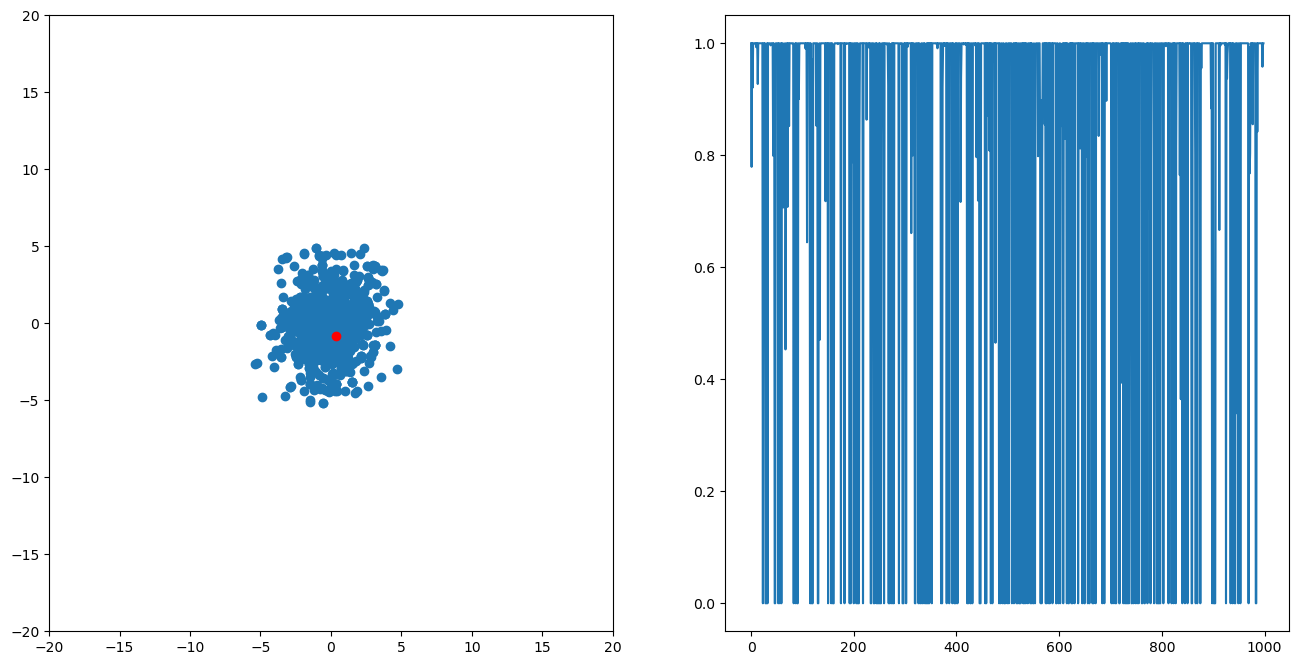

In [13]:
plot_mcmc_samples(samples_hmc, r_hmc, x0, M, C)

In [14]:
def get_norm_conv(samples, M, C):
    norm_m = []
    norm_c = []
    for i in range(10, N_samples):
        if jnp.mod(i, 50) == 0:
            Merr = jnp.linalg.norm(jnp.mean(samples[:i], axis=0) - M)
            Cerr = jnp.linalg.norm(
                jnp.cov(samples[:i].transpose()) - C
            ) / jnp.linalg.norm(C)
            norm_m.append(Merr)
            norm_c.append(Cerr)

    norm_m = jnp.array(norm_m)
    norm_c = jnp.array(norm_c)
    return norm_m, norm_c

In [15]:
samples_hmc.shape

(999, 10)

In [16]:
norm_m_hmc, norm_c_hmc = get_norm_conv(samples_hmc, M, C)

In [17]:
norm_m_an, norm_c_an = get_norm_conv(S, M, C)

In [19]:
xx = []
for i in range(50, N_samples):
    if jnp.mod(i, 50) == 0:
        xx.append(i)
xx = jnp.array(xx)
yy = 1 / jnp.sqrt(xx)

In [20]:
norm_m_hmc.shape

(19,)

In [21]:
xx.shape

(19,)

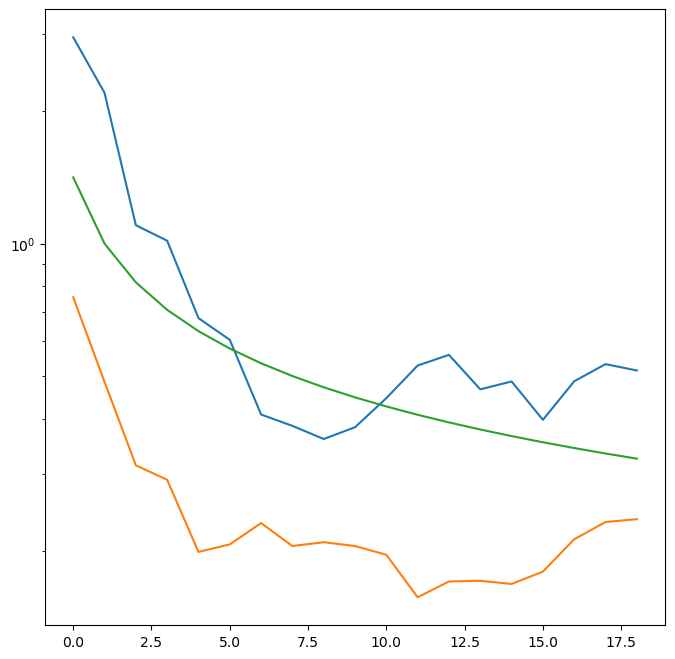

In [22]:
# plt.semilogy(norm_m_mala)
plt.semilogy(norm_m_hmc)
plt.semilogy(norm_m_an)
plt.semilogy(yy * 10)

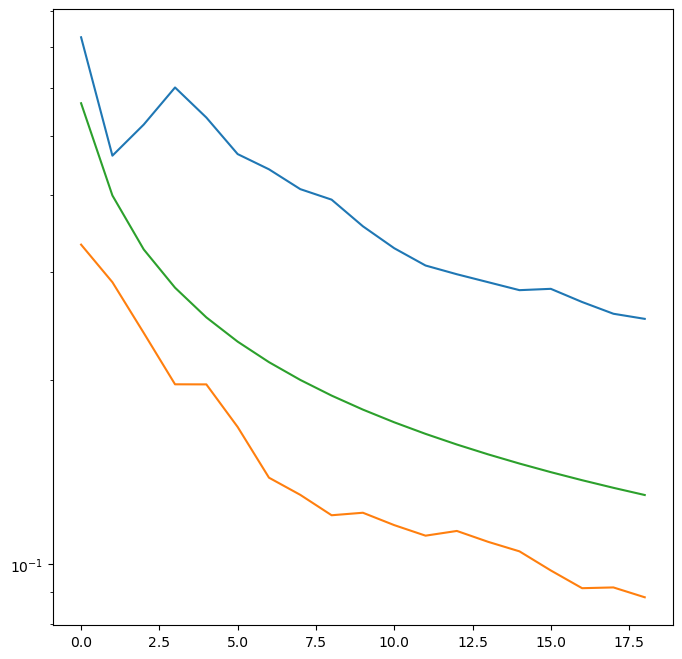

In [23]:
# plt.semilogy(norm_c_mala)
plt.semilogy(norm_c_hmc)
plt.semilogy(norm_c_an)
plt.semilogy(yy * 4)